In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
# Set directory as default system path
import sys
sys.path.append('/content/drive/MyDrive/smart-pixels')

Mounted at /content/drive


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import keras
import pandas as pd
import numpy as np
from global_vars import * 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from models import MultiOutputRegModel
from custom_callbacks import CustomCallback
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt

Num GPUs Available:  1


In [3]:
class DataGenerator:
    
    def __init__(self, nsamples, drop_cols = None):
        self.n = nsamples
        df1 = pd.read_csv(CLUSTERS_FILE)
        df2 = pd.read_csv(LABELS_FILE)
        
        self.X = df1.values
        n = self.X.shape[0]
        self.X = np.reshape(self.X, (n,13,21,1))
        
        if drop_cols != None:
            df2.drop(drop_cols, axis=1, inplace=True)
            
        print(df2.head())
        self.y = df2

        # scale all outputs to homogenize output

        self.y['x-entry'] = self.y['x-entry']/1000.
        self.y['y-entry'] = self.y['y-entry']/100.
        # self.y['cotAlpha'] = self.y['cotAlpha']/10.

        print(self.y.head())
     
    def get_train_test_split(self, test_size = 0.2, seed = 0):
        X_train, X_test, y_train, y_test = train_test_split(self.X,
                                                            self.y,
                                                            test_size = test_size, 
                                                            random_state = seed)
        print(self.X.shape, self.y.shape)
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        #scale input data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

        x_entry_train, x_entry_test = np.array(y_train['x-entry']),np.array(y_test['x-entry'])
        y_entry_train, y_entry_test = np.array(y_train['y-entry']),np.array(y_test['y-entry'])
        cotAlpha_train, cotAlpha_test = np.array(y_train['cotAlpha']),np.array(y_test['cotAlpha'])
        cotBeta_train, cotBeta_test = np.array(y_train['cotBeta']),np.array(y_test['cotBeta'])

        trainY = (np.column_stack([x_entry_train, y_entry_train]), np.column_stack([cotAlpha_train, cotBeta_train]))
        testY = (np.column_stack([x_entry_test, y_entry_test]), np.column_stack([cotAlpha_test, cotBeta_test]))

        return X_train, X_test, trainY, testY

In [4]:
datagen = DataGenerator(nsamples= NEVENTS, 
                        drop_cols = ['n_x','n_y','n_z','number_eh_pairs','z-entry'])
X_train, X_test, trainY, testY = datagen.get_train_test_split(test_size = 0.20,  seed = 0)

      x-entry    y-entry  cotAlpha   cotBeta
0 -168.364151  -2.262124  3.696619  0.098554
1 -127.467667  15.197241  2.341443 -0.206051
2 -369.492645  -0.128008  7.428552 -0.017690
3 -365.951111  -4.567823  7.807505  0.044182
4 -200.628601  14.304100  3.911512 -0.191527
    x-entry   y-entry  cotAlpha   cotBeta
0 -0.168364 -0.022621  3.696619  0.098554
1 -0.127468  0.151972  2.341443 -0.206051
2 -0.369493 -0.001280  7.428552 -0.017690
3 -0.365951 -0.045678  7.807505  0.044182
4 -0.200629  0.143041  3.911512 -0.191527
(650000, 13, 21, 1) (650000, 4)
(520000, 13, 21, 1) (130000, 13, 21, 1) (520000, 4) (130000, 4)


In [8]:
from keras.layers import Input, Conv2D, Dense, Dropout, MaxPooling2D, Flatten, concatenate, BatchNormalization
from keras.models import  Model

class BranchedRegModel1:

    def build_default_hidden_layers(self, inputs):
        x = Conv2D ( filters = 8 , kernel_size = (3 , 3) , strides = (1 , 1) ,
                         activation = "relu" , name = "conv_1" ) ( inputs )
        x = Conv2D ( filters = 16 , kernel_size = (3 , 3) , strides = (1 , 1) ,
                         activation = "relu" , name = "conv_2" ) ( x )
        x = MaxPooling2D ( (2 , 2) , name = "maxpool_1" ) ( x )
        x = Conv2D ( filters = 32 , kernel_size = (3 , 3) , strides = (1 , 1) ,
                         activation = "relu" , name = "conv_3" ) ( x )
        x = MaxPooling2D ( (2 , 2) , name = "maxpool_2" ) ( x )

        return x

    def build_coords_branch(self,inputs):

        x = Flatten()(inputs)
        x = Dense(32, activation = "relu")(x)
        x = BatchNormalization ( ) ( x )
        x = Dense(16, activation = "relu")(x)
        x = BatchNormalization ( ) ( x )
        x = Dropout ( 0.05 ) ( x )
        x = Dense ( 2, activation = "linear", name = "coords_output" ) ( x )
        return x

    def build_angles_branch(self,inputs):
        x = Flatten()(inputs)
        x = Dense ( 32 , activation =  "relu") ( x )
        x = BatchNormalization ( ) ( x )
        x = Dropout ( 0.1 ) ( x )
        x = Dense ( 2, activation = "linear", name = "angles_output" ) ( x )
        return x

    def assemble_full_model(self,inputs_shape):
        inputs = Input ( shape = inputs_shape )
        common_branch_inputs = self.build_default_hidden_layers ( inputs )
        coords_output = self.build_coords_branch(common_branch_inputs)
        angles_output = self.build_angles_branch(common_branch_inputs)
        model = Model ( inputs = inputs ,
                        outputs = [coords_output,angles_output],
                        name = "model_1" )
        model.summary()
        return model

In [ ]:
model = BranchedRegModel1().assemble_full_model(inputs_shape=(13,21,1))

checkpoint_path = "./models/multi_output_model_cp.ckpt"

# Create a callback that saves the model's weights 
# currently, model weights are saved for each training
# to do - update for early stopping
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              verbose=1,
                              save_best_only = True)

csv_logger = CSVLogger('log.csv', append=True, separator=';')
# es = EarlyStopping(monitor = "val_loss",patience=20, min_delta = 1e-5,mode="min")
batch_size = 128
init_lr = 0.05
epochs = 50
opt = Adam(lr=init_lr, decay=init_lr / epochs)

model.compile(loss = {'coords_output': 'mse',
                      'angles_output': 'mse'},
              optimizer=opt,  
              metrics= {'coords_output': MeanSquaredError(),
                      'angles_output': MeanSquaredError()},
              loss_weights= {'coords_output': 1. ,
                            'angles_output': 0.5}       
             )

history = model.fit(
          X_train, trainY,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, testY),
          callbacks=[cp_callback, csv_logger],
          )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13, 21, 1)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 11, 19, 8)    80          ['input_1[0][0]']                
                                                                                                  
 conv_2 (Conv2D)                (None, 9, 17, 16)    1168        ['conv_1[0][0]']                 
                                                                                                  
 maxpool_1 (MaxPooling2D)       (None, 4, 8, 16)     0           ['conv_2[0][0]']                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
4062/4063 [============================>.] - ETA: 0s - loss: 0.1331 - coords_output_loss: 0.0031 - angles_output_loss: 0.2601 - coords_output_mean_squared_error: 0.0031 - angles_output_mean_squared_error: 0.2601
Epoch 1: val_loss improved from inf to 0.04109, saving model to ./models/multi_output_model_cp.ckpt
4063/4063 [==============================] - 54s 11ms/step - loss: 0.1331 - coords_output_loss: 0.0031 - angles_output_loss: 0.2601 - coords_output_mean_squared_error: 0.0031 - angles_output_mean_squared_error: 0.2601 - val_loss: 0.0411 - val_coords_output_loss: 8.1686e-04 - val_angles_output_loss: 0.0806 - val_coords_output_mean_squared_error: 8.1686e-04 - val_angles_output_mean_squared_error: 0.0805
Epoch 2/50
4060/4063 [============================>.] - ETA: 0s - loss: 0.0999 - coords_output_loss: 9.4267e-04 - angles_output_loss: 0.1980 - coords_output_mean_squared_error: 9.4267e-04 - angles_output_mean_squared_error: 0.1980
Epoch 2: val_loss did not improve from 0.

In [ ]:
res = model.evaluate(
    X_test, y_test, batch_size=batch_size,
)

predictions = model.predict(X_test, batch_size=batch_size, callbacks=[CustomCallback()])

# print(len(predictions))
# df_predict = pd.DataFrame(predictions, columns=['x_entry', 'y_entry', 'cotAlpha', 'cotBeta'])
# trueLabels = pd.DataFrame(y_test, columns=['x_entry', 'y_entry', 'cotAlpha', 'cotBeta'])

In [ ]:
def calc_residuals(y, y_pred):
    res = y - y_pred
    return np.mean(res), np.std(res)

res = []
for col in df_predict.columns:
    mean,sd = calc_residuals(trueLabels[col],df_predict[col])
    res.append([col, mean, sd])

In [ ]:
pd.DataFrame(res, columns = ["variable","mean", "std"], index = None)

In [ ]:
plt.rcParams['font.family'] = [u'serif']
plt.rcParams['legend.title_fontsize'] = 'xx-small'
fig = plt.figure(figsize = (5,5), dpi = 75)
plt.plot(history.history['loss'], label='train_loss', color = "black")
plt.plot(history.history['val_loss'], label = 'val_loss', color = "red")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.25', alpha=0.5,color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.25', alpha=0.5,color='black')
plt.title("loss curve")
plt.show()

In [ ]:
plt.rcParams['font.family'] = [u'serif']
plt.rcParams['legend.title_fontsize'] = 'xx-small'
fig = plt.figure(figsize = (5,5), dpi = 75)
plt.plot(history.history['val_mean_squared_error'], label='val_mse', color = "blue")
plt.plot(history.history['mean_squared_error'], label = 'mse', color = "red")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.25', alpha=0.5,color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.25', alpha=0.5,color='black')
# plt.title("loss curve")
plt.show()

In [ ]:
# def saving_model(model,
#                  filepath:str ='',
#                  model_filename:str ='model'):
#     """
#     Helper function to save the trained pruned models in the following format:
#         Config -> JSON file format
#         Weights -> H5PY file format
#     :param model: Keras Model object
#     :param filepath: path to store the file in the directory
#     :param model_filename: name for the model
#     :return: None
#     """ 
#     # serialize model to JSON
#     model_json = model.to_json()
#     with open(filepath + "/" + model_filename + ".json", "w") as json_file:
#         json_file.write(model_json)
#     # serialize weights to HDF5
#     model.save_weights(filepath + "/" + model_filename + "_weights.h5")
#     print("Saved model to disk")

In [ ]:
# saving_model(model, filepath = sys.path[-1] + "/" + "models", model_filename = "BRM_02")

### **Model Evaluation:**

In [ ]:
from keras.models import model_from_json
def load_model(model_filename):
        model_path = sys.path[-1] + "/models/" + model_filename + ".json"
        print ( model_path )
        model_weights_path = sys.path[-1] + "/models/" + model_filename + "_weights.h5"
        print ( model_weights_path )
        with open ( model_path , 'r' ) as f :
            loaded_model_json = f.read ( )
        loaded_model = model_from_json ( loaded_model_json )
        loaded_model.load_weights ( model_weights_path )

        return loaded_model

In [ ]:
model = load_model(model_filename = "BRM_02")

/content/drive/MyDrive/smart-pixels/models/BRM_02.json
/content/drive/MyDrive/smart-pixels/models/BRM_02_weights.h5


In [ ]:
predictions = model.predict(X_test, batch_size=64, callbacks=[CustomCallback()])
print(len(predictions))
df_predict = pd.DataFrame(predictions, columns=['x_entry', 'y_entry', 'cotAlpha', 'cotBeta'])
trueLabels = pd.DataFrame(y_test, columns=['x_entry', 'y_entry', 'cotAlpha', 'cotBeta'])

Start predicting; got log keys: []
Stop predicting; got log keys: []
130000


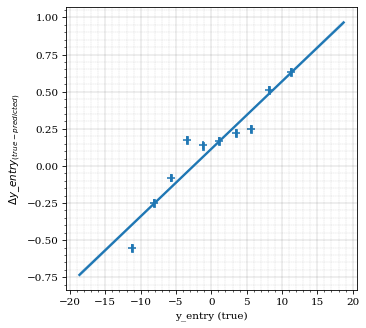

In [ ]:
plt.rcParams['font.family'] = [u'serif']
fig = plt.figure(figsize = (5,5), dpi = 75)
# sns.scatterplot(x = trueLabels['y_entry'], y = trueLabels['y_entry'] - df_predict['x_entry'])
sns.regplot(x=trueLabels['y_entry'], y=trueLabels['y_entry'] - df_predict['y_entry'], x_bins=10, marker='+', fit_reg = True, x_estimator = np.mean)
plt.xlabel(r'y_entry (true)')
plt.ylabel(r'$\Delta y\_entry_{(true - predicted)}$')
# plt.xlim([-0.3,0.3])
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.25', alpha=0.5,color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.25', alpha=0.5,color='black')
plt.show()

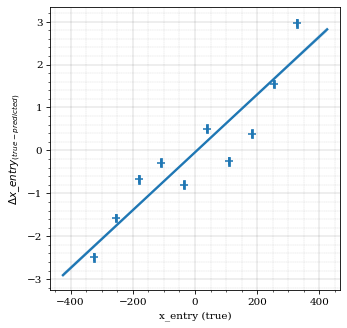

In [ ]:
plt.rcParams['font.family'] = [u'serif']
fig = plt.figure(figsize = (5,5), dpi = 75)
sns.regplot(x=trueLabels['x_entry'], y=trueLabels['x_entry'] - df_predict['x_entry'], x_bins=10, marker='+', fit_reg = True, x_estimator = np.mean)
plt.xlabel(r'x_entry (true)')
plt.ylabel(r'$\Delta x\_entry_{(true - predicted)}$')
# plt.xlim([-0.3,0.3])
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.25', alpha=0.5,color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.25', alpha=0.5,color='black')
plt.show()

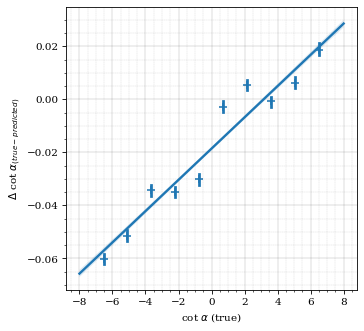

In [ ]:
plt.rcParams['font.family'] = [u'serif']
fig = plt.figure(figsize = (5,5), dpi = 75)
sns.regplot(x=trueLabels['cotAlpha'], y=trueLabels['cotAlpha'] - df_predict['cotAlpha'], x_bins=10, marker='+', fit_reg = True, x_estimator = np.mean)
plt.xlabel(r'cot $\alpha$ (true)')
plt.ylabel(r'$\Delta$ cot $\alpha_{(true - predicted)}$')
# plt.xlim([-0.3,0.3])
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.25', alpha=0.5,color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.25', alpha=0.5,color='black')
plt.show()

In [ ]:
plt.rcParams['font.family'] = [u'serif']
fig = plt.figure(figsize = (5,5), dpi = 75)
sns.regplot(x=trueLabels['cotBeta'], y=trueLabels['cotBeta'] - df_predict['cotBeta'], x_bins=10, marker='+', fit_reg = True, x_estimator = np.mean)
plt.xlabel(r'cot $\beta$ (true)')
plt.ylabel(r'$\Delta$ cot $\beta_{(true - predicted)}$')
# plt.xlim([-0.3,0.3])
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.25', alpha=0.5,color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.25', alpha=0.5,color='black')
plt.show()

NameError: ignored

In [ ]:
X, Y = np.array(trueLabels['cotAlpha']), np.array(trueLabels['cotAlpha'] - df_predict['cotAlpha'])
from scipy.stats import pearsonr, spearmanr
print(pearsonr(X,Y))
print(spearmanr(X,Y))
# covXY = np.cov(X,Y)
# stdX, stdY = np.std(X), np.std(Y)
# corr = covXY/(stdX*stdY)
# print(corr)

(0.22468646777188006, 0.0)
SpearmanrResult(correlation=0.23589007491824784, pvalue=0.0)


In [ ]:
sns.distplot(df_predict['x_entry'], kde= False, bins=100)
plt.xlabel(r'x_entry ($\mu$m)')
plt.ylabel('frequency')
plt.xlim([-500,500])
plt.title("x_entry (predicted)")
plt.show()

In [ ]:
sns.distplot(trueLabels['x_entry'] - df_predict['x_entry'], kde=False, bins=100)
plt.xlabel(r'x_entry ($\mu$m)')
plt.ylabel('frequency')
plt.xlim([-50,50])
plt.title("x_entry residuals")
plt.show()

In [ ]:
sns.distplot(df_predict['y_entry'], kde=False, bins=100)
plt.xlabel(r'y_entry ($\mu$m)')
plt.xlim([-20,20])
plt.ylabel('frequency')
plt.title("y_entry (predicted)")
plt.show()

In [ ]:
sns.distplot(trueLabels['y_entry']-df_predict['y_entry'], kde=False, bins=100)
plt.xlabel(r'y_entry residual ($\mu$m)')
plt.ylabel('frequency')
plt.xlim([-10,10])
plt.title('y-entry residuals')
plt.show()

In [ ]:
sns.distplot(df_predict['cotBeta'], kde=False, bins=100)
plt.xlabel(r'cot$\beta$')
plt.ylabel('frequency')
plt.xlim([-0.4,0.4])
plt.title(r'cot$\beta$ (predicted)')

In [ ]:
sns.distplot(trueLabels['cotBeta']-df_predict['cotBeta'], kde=False, bins=100)
plt.xlabel(r'cot$\beta$')
plt.ylabel('frequency')
plt.xlim([-.2,.2])
plt.title(r'cot$\beta$ residuals')
plt.show()

In [ ]:
sns.distplot(trueLabels['cotAlpha']-df_predict['cotAlpha'], kde=False, bins=100)
plt.xlabel(r'cot$\alpha$')
plt.ylabel('frequency')
plt.xlim([-2,2])
plt.title(r'cot$\alpha$ residuals')
plt.show()

In [ ]:
sns.distplot(trueLabels['cotAlpha'], kde=False, bins=100)
# sns.distplot(df_predict['cotAlpha'], kde=False, bins=100)
plt.xlabel(r'cot$\alpha$')
plt.ylabel('frequency')
plt.xlim([-10,10])
plt.title(r'cot$\alpha$ (true)')
plt.show()